In [1]:
import pandas as pd
import numpy as np
import torch
import os
import sys
from tqdm import tqdm, trange
import time
import copy

import argparse
from matplotlib import pyplot as plt
# from importlib import invalidate_caches
# invalidate_caches()

from libmoon.solver.gradient import MGDASolver, GradAggSolver, EPOSolver, MOOSVGDSolver, GradHVSolver, PMTLSolver
from libmoon.util_global.constant import problem_dict
from libmoon.util_global.weight_factor.funs import uniform_pref
from libmoon.visulization.view_res import vedio_res
from libmoon.problem.mop import mop

from bikebench.benchmarking.public_benchmarking_utils import Benchmarker, get_unconditionally_valid_sample, ScoreReportDashboard

In [2]:
device = "cpu"

In [3]:
# --- Problem with one-time cached evaluation + variance-based scaling ---
class MOOProblem(mop):
    def __init__(self, bench, condition=None, device=None, penalty_weight=1e3):
        self.bench = bench
        self.condition = condition
        self.device = device
        self.penalty_weight = penalty_weight

        # single torch mask (no NumPy twin)
        self.is_objective = torch.tensor(np.array(bench.is_objective, dtype=bool),
                                         dtype=torch.bool, device=device)
        self.requirement_names = bench.requirement_names
        self.objective_names = np.array(self.requirement_names)[np.array(bench.is_objective, dtype=bool)]

        # variable bounds from train (pad zero-width dims)
        Xtrain = bench.get_train_data()
        n_var = Xtrain.shape[1]
        lbound, _ = torch.min(Xtrain, axis=0)
        ubound, _ = torch.max(Xtrain, axis=0)

        super().__init__(n_var=n_var, n_obj=int(self.is_objective.sum().item()),
                         lbound=lbound, ubound=ubound)

        self.problem_name = 'MOO'

        # ---- One-time cached evaluation on train set ----
        
        with torch.no_grad():
            S_train = self.bench.evaluate(Xtrain, self.condition)

        F_train = S_train[:, self.is_objective]            # objectives (N, n_obj)
        C_train = S_train[:, ~self.is_objective]           # constraints (N, n_cons) or empty

        # per-objective std scaling (no mean-centering)
        obj_std = F_train.std(dim=0).clamp_min(1e-6)       # (n_obj,)
        self._obj_std = obj_std
        self._penalty_scale = obj_std.mean()               # scalar to scale sum of violations

        # cache scaled objectives and (scaled) penalty term for seeds
        F_scaled = F_train / self._obj_std                 # (N, n_obj)
        if C_train.numel() > 0:
            viol_sum_scaled = torch.clamp(C_train, min=0.0).sum(dim=1, keepdim=True) / self._penalty_scale
        else:
            viol_sum_scaled = torch.zeros((F_scaled.size(0), 1), device=device)

        self.penalized_F_train_scaled = F_scaled + self.penalty_weight * viol_sum_scaled  # (N, n_obj)
        self.X_train = Xtrain                             # (N, n_var)

        # scale ref point so HV/solver see the same space
        ref_full = torch.as_tensor(bench.ref_point, dtype=torch.float32, device=device)

        ref_obj = ref_full[self.is_objective]

        # Scale ref point into the same space as eval_fn (variance/std scaling):
        self.ref_point = ref_obj / self._obj_std  # shape: (n_obj,)

    def eval_fn(self, x, condition):
        scores = self.bench.evaluate(x, condition)        # (B, n_req)
        F = scores[:, self.is_objective]                  # (B, n_obj)
        C = scores[:, ~self.is_objective]                 # (B, n_cons) or empty

        F_scaled = F / self._obj_std
        if C.numel() > 0:
            penalty_scaled = torch.clamp(C, min=0.0).sum(dim=1, keepdim=True) / self._penalty_scale
        else:
            penalty_scaled = torch.zeros((x.size(0), 1), device=x.device)

        return F_scaled + self.penalty_weight * penalty_scaled  # minimized, scaled

    def _evaluate_torch(self, x):
        return self.eval_fn(x, self.condition)


In [4]:
import torch
from types import SimpleNamespace

# --- Helper: choose one x0 per pref by scalarizing all train points ---
# --- Helper: evaluate all train designs with the problem's true objective function, pick best per pref ---
# --- Smart x0 using ONLY cached train evaluation (no extra evaluator calls) ---
@torch.no_grad()
def select_smart_x0_cached(problem: MOOProblem, prefs: torch.Tensor, agg: str = "tche"):
    """
    Uses `problem.penalized_F_train_scaled` and `problem.X_train` to pick one seed per pref.
    No new calls to bench.evaluate.
    """
    Fpen = problem.penalized_F_train_scaled            # (N, n_obj) minimized, scaled, penalized
    if prefs.shape[1] != Fpen.shape[1]:
        raise RuntimeError(f"prefs has {prefs.shape[1]} objectives but problem has {Fpen.shape[1]}.")

    if agg == "lin":
        values = Fpen @ prefs.T                        # (N, n_prob)
    elif agg == "tche":
        z = Fpen.min(dim=0, keepdim=True).values       # empirical ideal in scaled space
        values = torch.max(torch.abs(Fpen.unsqueeze(1) - z) * prefs.unsqueeze(0), dim=2).values  # (N, n_prob)
    else:
        raise ValueError("agg must be 'lin' or 'tche'")

    best_idx = torch.argmin(values, dim=0)             # (n_prob,)
    return problem.X_train[best_idx]                    # (n_prob, n_var)

# --- Lean run_solver (keeps your original uniform_pref), zero redundant evals ---
from types import SimpleNamespace

def run_solver(
    bench,
    cond_idx: int,
    solver_name: str = "Agg-LS",
    device: str = "cpu",
    n_partition: int = 2,       # your original lattice; with 10 objs and H=2 this yields 55 prefs
    agg: str = "tche",
    target_num: int = 100,
    penalty_weight: float = 1e3,
):
    # Problem / condition (this does ONE pass over train to cache scores)
    condition = bench.get_single_test_condition(cond_idx)
    problem = MOOProblem(bench, condition=condition, device=device, penalty_weight=penalty_weight)

    # Preferences via your original method
    prefs = torch.tensor(
        uniform_pref(n_partition, int(problem.n_obj), clip_eps=1e-2),
        dtype=torch.float32, device=device
    )
    args = SimpleNamespace(
        agg=agg, solver="agg",
        n_obj=int(problem.n_obj), n_var=int(problem.n_var), n_prob=len(prefs),
        n_partition=n_partition,
    )

    # Smart x0 from cached train evaluations (no extra evaluator call)
    x0 = select_smart_x0_cached(problem, prefs, agg=agg)

    solver = GradAggSolver(1.0, 126, 1e-6, device) # 10k per condition - 3045 for initial evaluation //55 for prefs -> 126

    # Solve
    res = solver.solve(problem, x=x0, prefs=prefs, args=args, ref_point=problem.ref_point)

    # Post-process
    res_x = torch.as_tensor(res["x"], dtype=torch.float32, device=device)
    finite_mask = torch.isfinite(res_x).all(dim=1)
    res_x = res_x[finite_mask]
    if res_x.numel() == 0:
        raise RuntimeError("All solutions contained NaNs/Infs; nothing to return.")
    if res_x.shape[1] != x0.shape[1]:
        raise RuntimeError(f"Result dimensionality mismatch: got {res_x.shape[1]} vs x0 {x0.shape[1]}.")

    if res_x.size(0) < target_num:
        reps = (target_num + res_x.size(0) - 1) // res_x.size(0)
        res_x = res_x.repeat(reps, 1)
    return res_x[:target_num]


In [5]:
bench = Benchmarker(device=device, masked_constraints=False, gradient_free=False)

stacked_results = []
for i in range(100):
    solver = 'Agg-LS'
    result = run_solver(bench, cond_idx=i, solver_name=solver, device=device)
    stacked_results.append(result.cpu().numpy())
stacked_results = np.vstack(stacked_results)

100%|██████████| 126/126 [00:01<00:00, 66.67it/s]


In [6]:
stacked_results = torch.tensor(stacked_results, dtype=torch.float32)
main_scores_GD, detailed_scores_GD, all_evaluation_scores_GD = bench.score(stacked_results)

bench.save_results("results/benchmark_results/GD")

print(main_scores_GD)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:08<00:00, 12.22it/s]

Design Quality ↑ (HV)      0.016416
Constraint Violation ↓       0.0919
Sim. to Data ↓ (MMD)       0.265791
Novelty ↑                  18.33922
Binary Validity ↑            0.9414
Diversity ↓ (DPP)         12.036111
Evaluation Count           996600.0
Conditional?                  False
Masked Constraints?           False
gradient_free?                False
dtype: object


In [7]:
bench_masked = Benchmarker(device=device, masked_constraints=True, gradient_free=False)

stacked_results = []
for i in range(100):
    solver = 'Agg-LS'
    result = run_solver(bench_masked, cond_idx=i, solver_name=solver, device=device)
    stacked_results.append(result.cpu().numpy())
stacked_results = np.vstack(stacked_results)

stacked_results = torch.tensor(stacked_results, dtype=torch.float32)
main_scores_GD_masked, detailed_scores_GD_masked, all_evaluation_scores_GD_masked = bench_masked.score(stacked_results)
bench_masked.save_results("results/benchmark_results/GD_masked")
print(main_scores_GD_masked)

100%|██████████| 100/100 [00:09<00:00, 10.30it/s]

Design Quality ↑ (HV)      0.016087
Constraint Violation ↓       0.6833
Sim. to Data ↓ (MMD)       0.279004
Novelty ↑                 16.876296
Binary Validity ↑            0.7123
Diversity ↓ (DPP)         12.085882
Evaluation Count           996600.0
Conditional?                  False
Masked Constraints?            True
gradient_free?                False
dtype: object


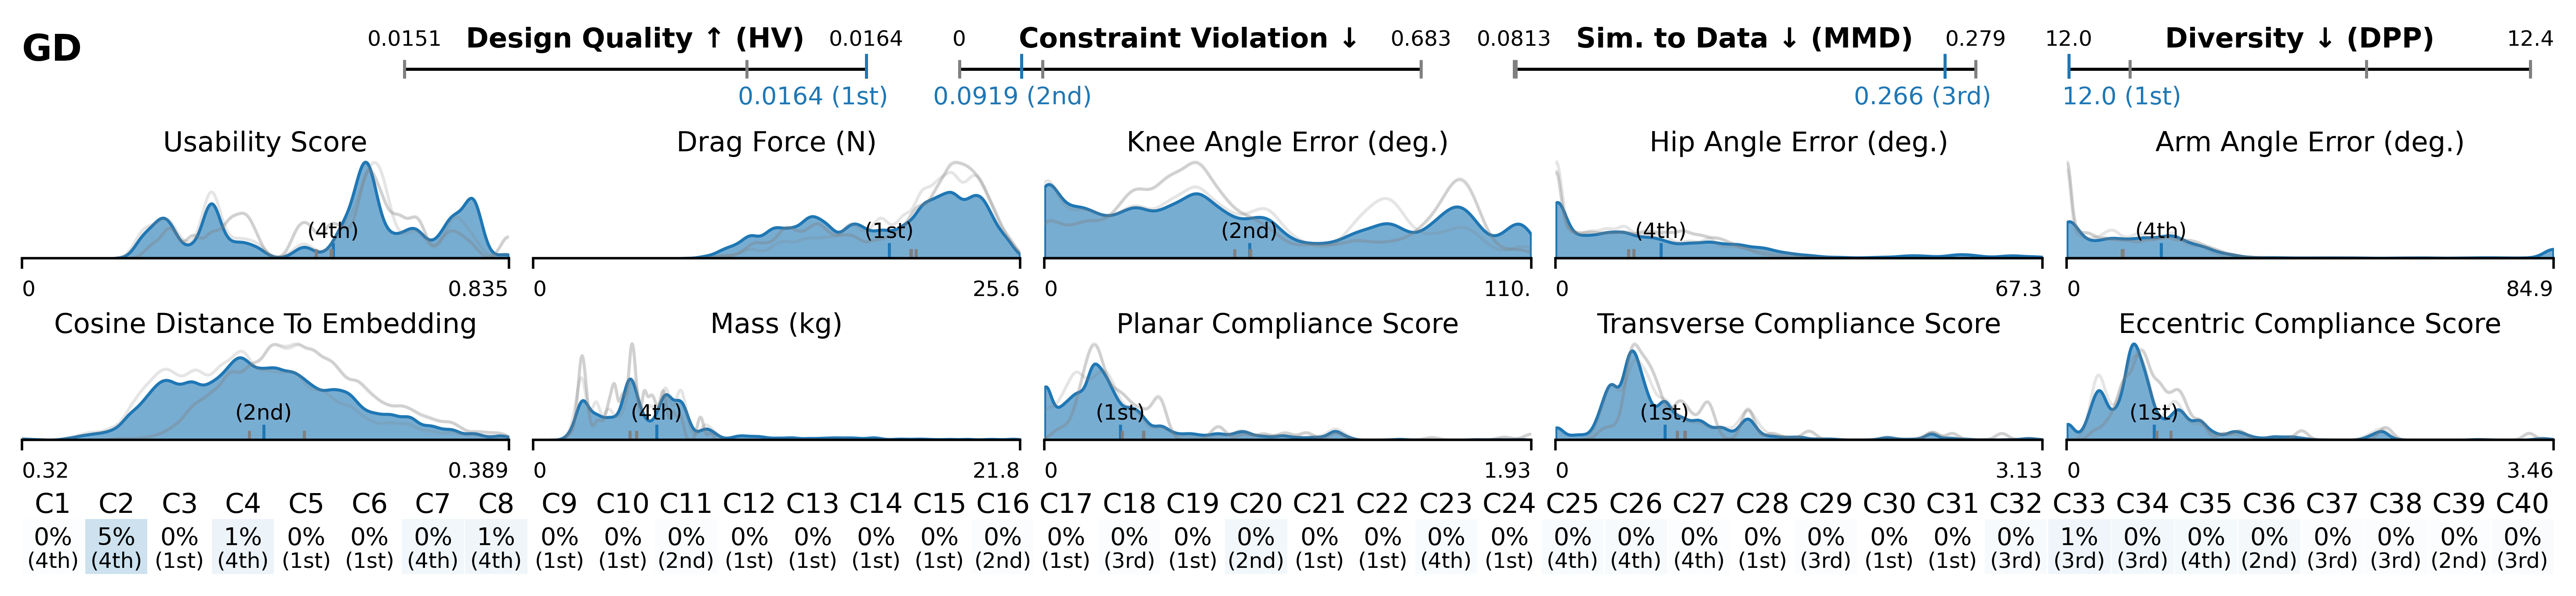

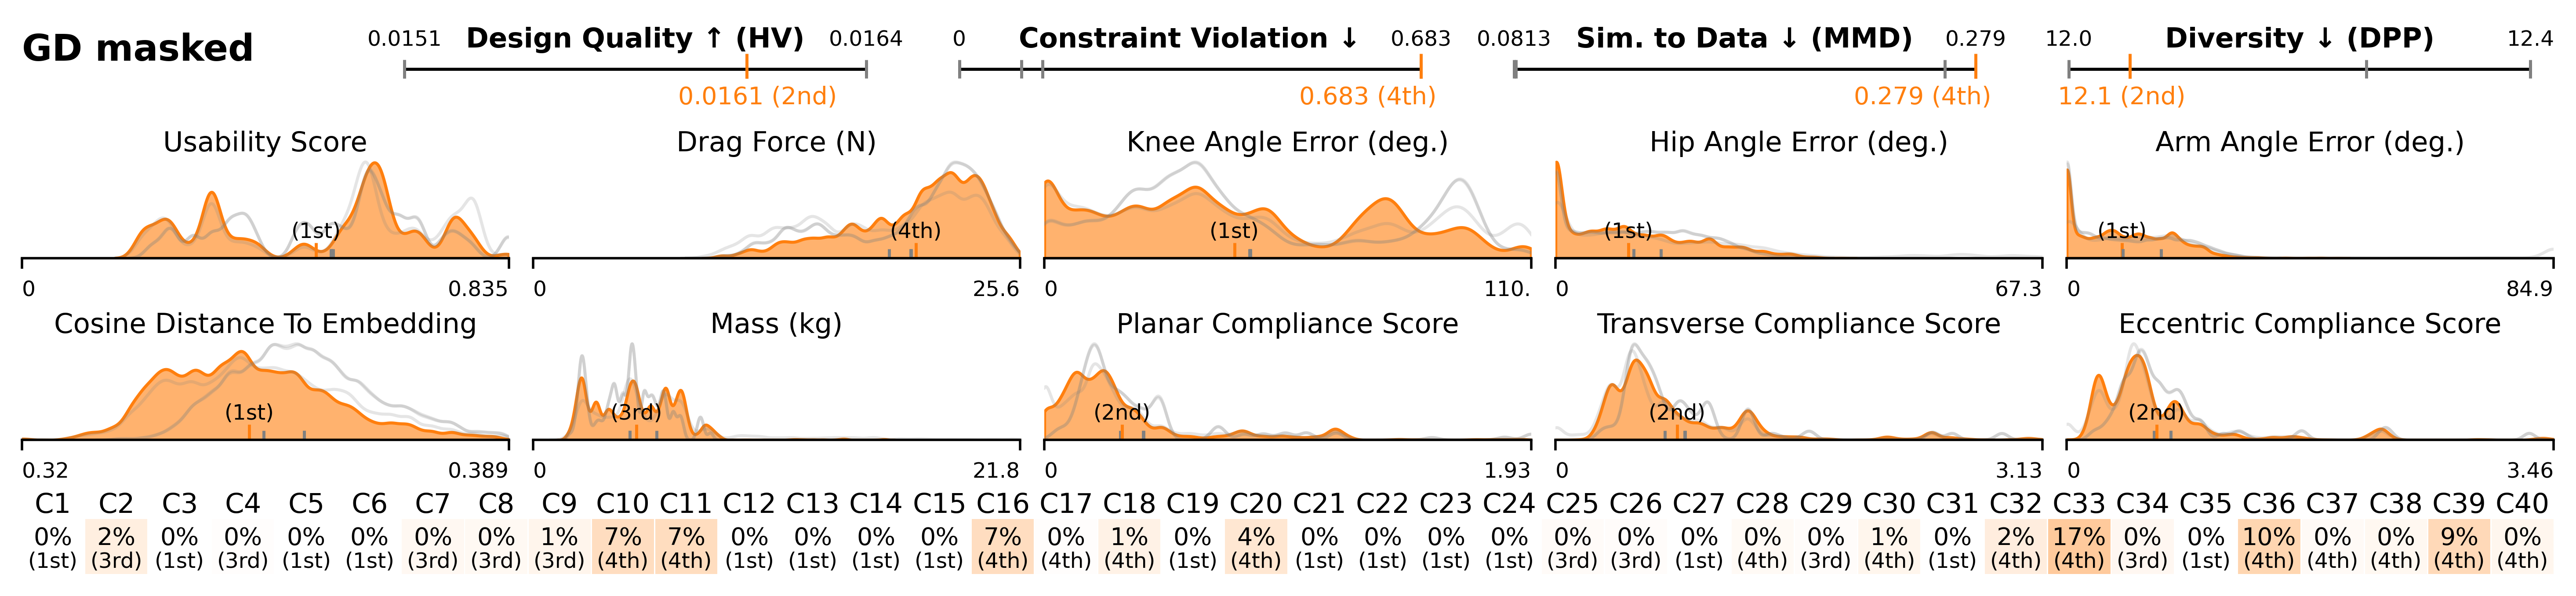

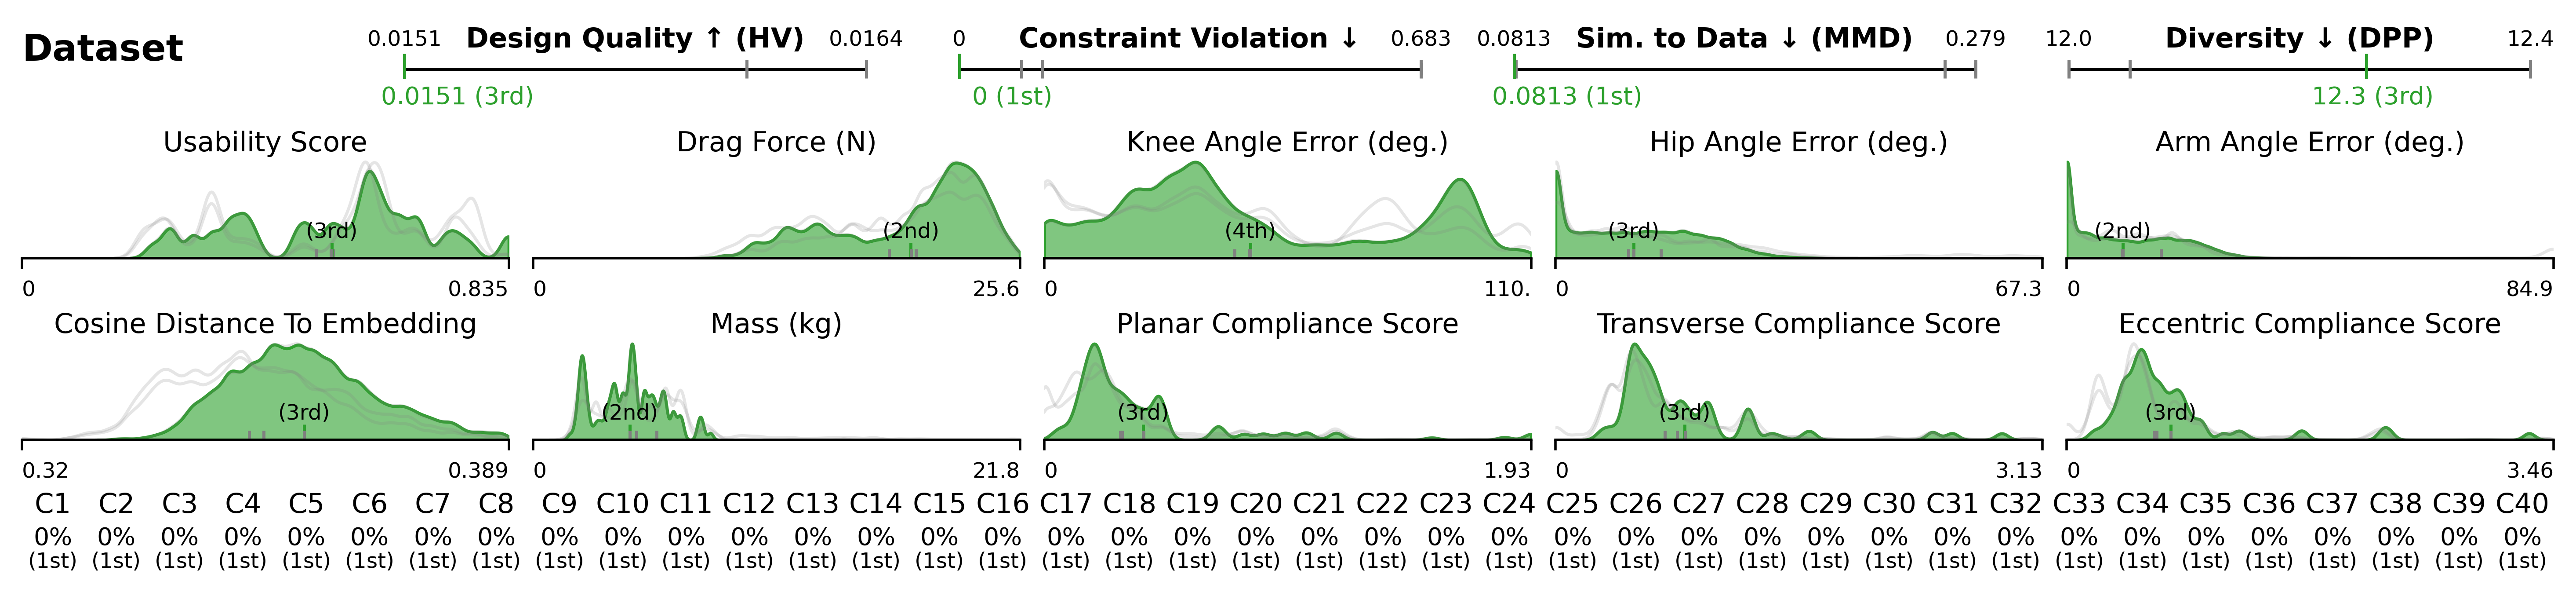

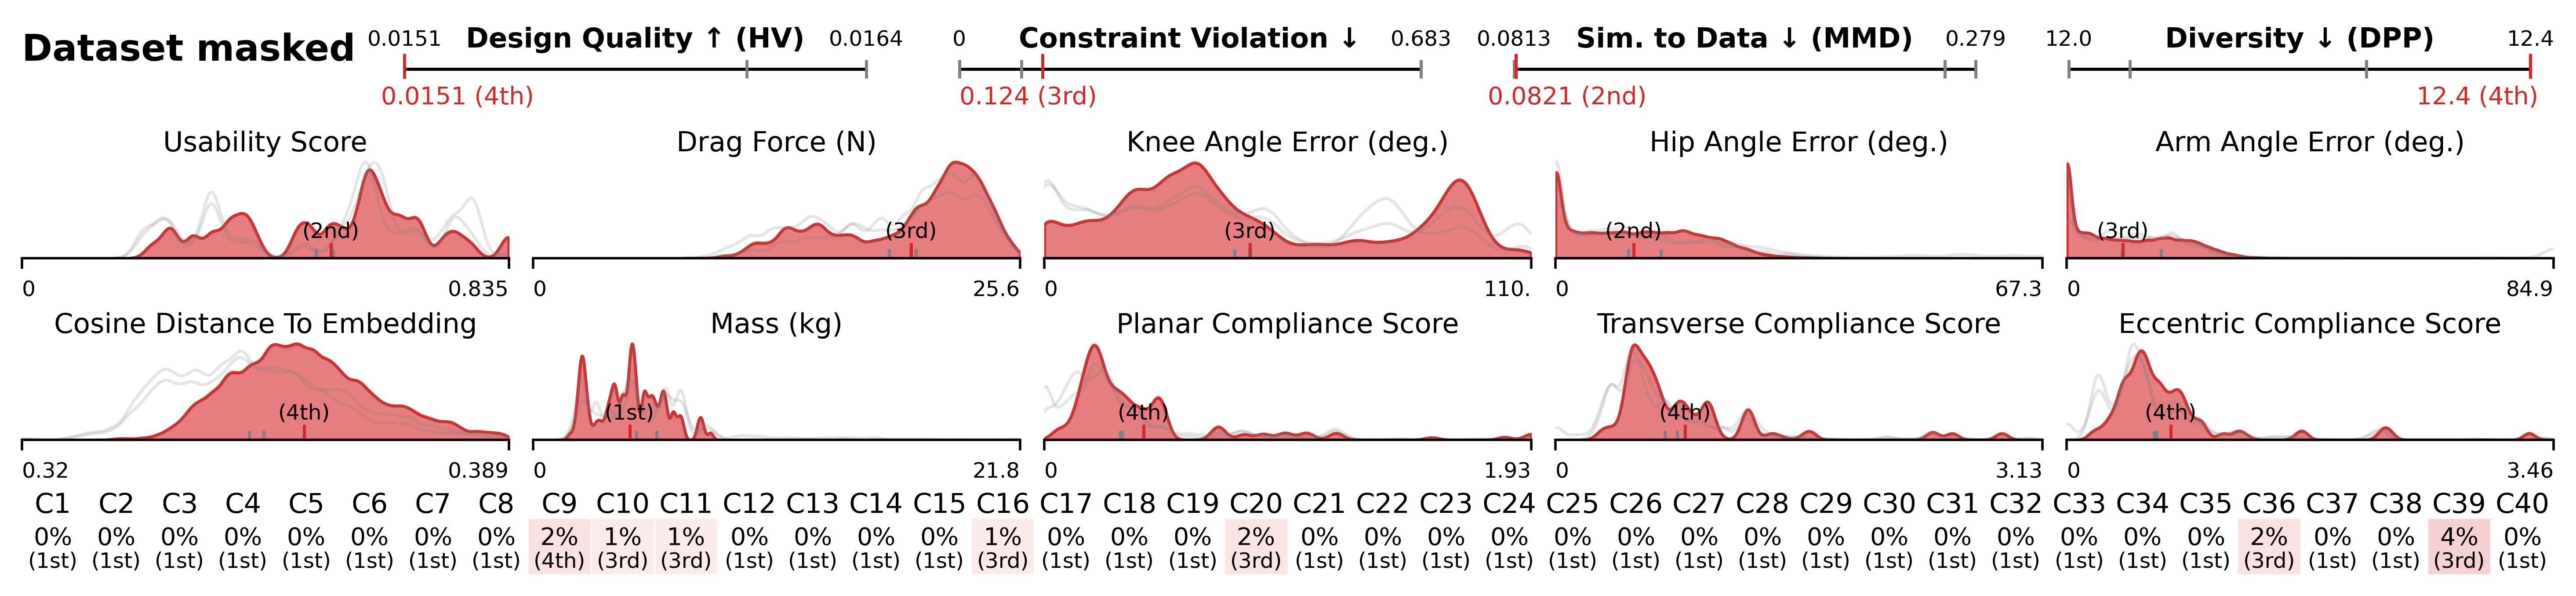

In [8]:
filepaths_conditional = {
    "GD": "results/benchmark_results/GD",
    "GD masked": "results/benchmark_results/GD_masked",
    "Dataset": "results/benchmark_results/baseline_dataset_conditional",
    "Dataset masked": "results/benchmark_results/baseline_dataset_masked_conditional"
}
dashboard_conditional = ScoreReportDashboard(
    filepaths = filepaths_conditional,
)
for m in filepaths_conditional.keys():
    dashboard_conditional.show_model(m)